<a href="https://colab.research.google.com/github/aiaaee/FashionMNIST/blob/main/Github_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil
import torch
import torch.nn.functional as f
from torch import nn , optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from torch.utils.data import random_split
from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
train_dataset = datasets.FashionMNIST('./data' , train=True , download=True , transform=ToTensor())
test_dataset = datasets.FashionMNIST('./data' , train=False , download=True ,  transform=ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 12407123.74it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199474.52it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3731105.75it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14569687.58it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_ds , val_ds = random_split(train_dataset , [50000 , 10000])

In [6]:
print('train dataset: '  , train_dataset.data.shape)
print('test dataset : '  , test_dataset.data.shape )

train dataset:  torch.Size([60000, 28, 28])
test dataset :  torch.Size([10000, 28, 28])


In [7]:
input_size = [*train_dataset.data.shape[1:]]
num_epoches = 10
batch_size = 32
learning_rate = 0.01

In [8]:
train_Dloader = DataLoader(train_ds , batch_size=batch_size , shuffle=True)
val_Dloader   = DataLoader(val_ds , batch_size=batch_size , shuffle=True )
test_Dloader  = DataLoader(test_dataset , batch_size=batch_size , shuffle=True)

In [9]:
for data , label in train_Dloader :
  print(data.shape , label.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


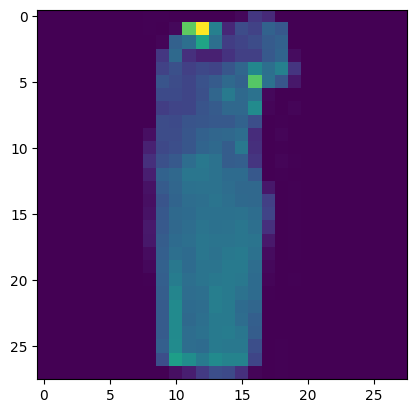

In [10]:
plt.imshow(data[6, 0 , : , :])

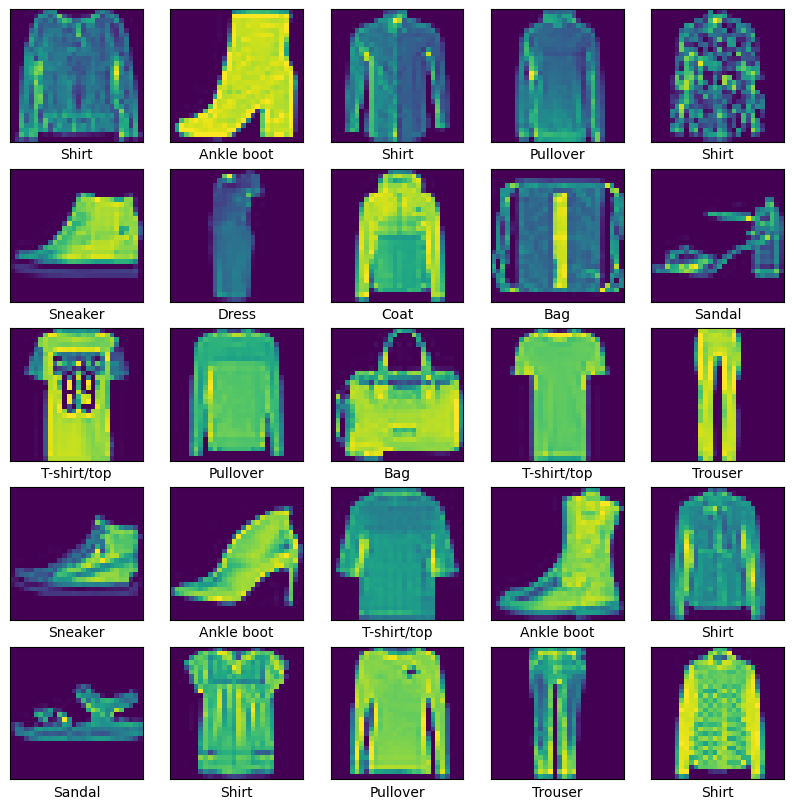

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i , 0 , : , : ])
    plt.xlabel(class_names[label[i]])
plt.show()

In [29]:
class NeuralNet(nn.Module):
  def __init__(self , in_feature:int , output_feature:int , *args , **kwargs):
    super().__init__(*args , **kwargs)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_feature , 300)
    self.bn1 = nn.BatchNorm1d(300)
    self.fc2 = nn.Linear(300 , 100)
    self.bn2 = nn.BatchNorm1d(100)
    self.fc3 = nn.Linear(100 , output_feature)
  def forward(self , x):
    x = self.flatten(x)
    output = self.bn1(self.fc1(x))
    output = nn.GELU()(output)
    output = self.bn2(self.fc2(output))
    output = nn.GELU()(output)
    return self.fc3(output)



In [30]:
model = NeuralNet(784 , 10).to(device)

model

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [31]:
#  A parameter that is assigned as an attribute inside a custom model is registered as a model parameter and is thus returned by the caller model. parameters().
model.parameters()

<generator object Module.parameters at 0x7dd03579d5b0>

In [32]:
#numel : Returns the total number of elements in the input tensor Parameters
counter = 1
for item in model.parameters():
  print("model parameters : " , counter)
  print(item.size())
  print(item.numel())
  counter +=1

model parameters :  1
torch.Size([300, 784])
235200
model parameters :  2
torch.Size([300])
300
model parameters :  3
torch.Size([300])
300
model parameters :  4
torch.Size([300])
300
model parameters :  5
torch.Size([100, 300])
30000
model parameters :  6
torch.Size([100])
100
model parameters :  7
torch.Size([100])
100
model parameters :  8
torch.Size([100])
100
model parameters :  9
torch.Size([10, 100])
1000
model parameters :  10
torch.Size([10])
10


In [33]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate)


In [34]:
num_epoches = 5
best_vloss = 1_000_000.
train_losses, val_losses = [], []

# Train & validate Network
for epoch in range(num_epoches):

    print(f'EPOCH {epoch + 1}:')

    running_loss = 0.
    last_loss = 0.

    model.train(True)
    for batch_idx, (data, targets) in enumerate(tqdm(train_Dloader)):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # Make predictions for this batch (forward)
        outputs = model(data)

        # Compute the loss and its gradients
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 500 == 499:
            last_loss = running_loss / 500 # loss per batch
            print(f'batch {batch_idx + 1} loss: {last_loss}')
            running_loss = 0.

    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vinputs, vlabels) in enumerate(val_Dloader):
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {last_loss} valid {avg_vloss}')

    train_losses.append(last_loss)
    val_losses.append(avg_vloss)

    epoch += 1


EPOCH 1:


 33%|███▎      | 511/1563 [00:04<00:08, 118.66it/s]

batch 500 loss: 0.6662551307082176


 65%|██████▌   | 1016/1563 [00:08<00:04, 114.85it/s]

batch 1000 loss: 0.5543839624226093


 97%|█████████▋| 1520/1563 [00:14<00:00, 107.23it/s]

batch 1500 loss: 0.5174021421968937


100%|██████████| 1563/1563 [00:14<00:00, 108.65it/s]


LOSS train 0.5174021421968937 valid 0.523824155330658
EPOCH 2:


 33%|███▎      | 521/1563 [00:04<00:08, 119.20it/s]

batch 500 loss: 0.5027207753062248


 65%|██████▌   | 1020/1563 [00:09<00:06, 90.05it/s]

batch 1000 loss: 0.5041966333091259


 97%|█████████▋| 1519/1563 [00:14<00:00, 115.48it/s]

batch 1500 loss: 0.4921800094842911


100%|██████████| 1563/1563 [00:14<00:00, 107.31it/s]


LOSS train 0.4921800094842911 valid 0.4822885990142822
EPOCH 3:


 33%|███▎      | 514/1563 [00:04<00:11, 89.42it/s]

batch 500 loss: 0.48533082437515257


 65%|██████▍   | 1013/1563 [00:09<00:04, 118.40it/s]

batch 1000 loss: 0.4860592718422413


 97%|█████████▋| 1512/1563 [00:13<00:00, 120.05it/s]

batch 1500 loss: 0.47449564093351365


100%|██████████| 1563/1563 [00:14<00:00, 110.35it/s]


LOSS train 0.47449564093351365 valid 0.48527082800865173
EPOCH 4:


 33%|███▎      | 518/1563 [00:05<00:09, 112.71it/s]

batch 500 loss: 0.4711008351445198


 66%|██████▌   | 1024/1563 [00:09<00:04, 116.70it/s]

batch 1000 loss: 0.47268610802292826


 97%|█████████▋| 1513/1563 [00:13<00:00, 83.61it/s]

batch 1500 loss: 0.4719237457513809


100%|██████████| 1563/1563 [00:14<00:00, 106.85it/s]


LOSS train 0.4719237457513809 valid 0.504554808139801
EPOCH 5:


 33%|███▎      | 522/1563 [00:04<00:08, 117.31it/s]

batch 500 loss: 0.45647975036501887


 65%|██████▌   | 1020/1563 [00:08<00:04, 119.66it/s]

batch 1000 loss: 0.45991810083389284


 97%|█████████▋| 1518/1563 [00:13<00:00, 115.33it/s]

batch 1500 loss: 0.4699587114751339


100%|██████████| 1563/1563 [00:14<00:00, 110.27it/s]


LOSS train 0.4699587114751339 valid 0.4817312955856323


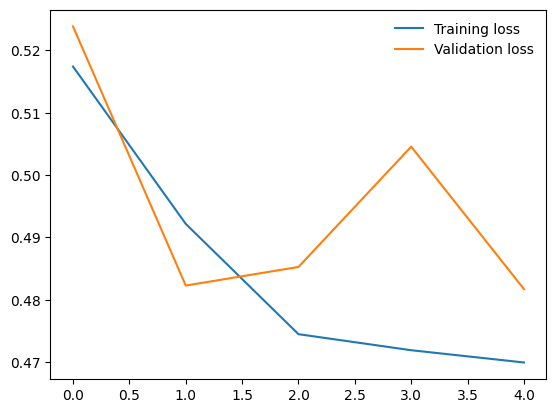

In [35]:
plt.plot(train_losses , label ="Training loss")
plt.plot(val_losses , label ="Validation loss")
plt.legend(frameon = False)